In [1]:
import pandas as pd # Used for dataframe functions
import json # parse json string
import nltk # Natural language toolkit for TDIDF etc.
from bs4 import BeautifulSoup # Parse html string .. to extract text
import re # Regex parser 
import numpy as np # Linear algebbra 
from sklearn import * # machine learning
import matplotlib.pyplot as plt # Visualization
from wordcloud import WordCloud # Word cloud visualization
import scipy #Sparse matrix 

np.set_printoptions(precision=4)
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10
pd.options.display.float_format = lambda f: "%.4f" % f

%matplotlib inline 

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be rem

Run the following line when you run this notebook first time.

In [2]:
# nltk.download("punkt")
# nltk.download("stopwords")

In [3]:
#import requests
#url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
#exec(requests.get(url).text)

In [4]:
print(nltk.__version__)

3.2.5


In [5]:
# The following line does not work on Windows system
!head -n 1 /data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


In [6]:
data = []
with open("/data/imdb-comments.json", "r", encoding="utf8") as f:
    for l in f.readlines():
        data.append(json.loads(l))    

In [7]:
comments = pd.DataFrame.from_dict(data)
comments.sample(10)

,content,label,name,sentiment
4163,The Love Letter is one of my all-time favorite...,test,2498_7.txt,pos
48552,Carnosaur 3 is bad... awfully bad. Bad to the ...,train,8699_1.txt,neg
18797,"""Bar Hopping"" seems to be trying to be about t...",test,4418_3.txt,neg
15580,Possibly the worst film within the genre in ex...,test,1522_1.txt,neg
22041,What a dire film. I cannot believe that I actu...,test,7338_1.txt,neg
24598,DANGER: Watch for falling spoilers...<br /><br...,test,963_2.txt,neg
30984,I have become quite fond of Laurence Olivier i...,train,4136_10.txt,pos
49039,"When the film began, I was shocked to see it w...",train,9136_1.txt,neg
3231,This 1955 heist film follows Tony le Stephanoi...,test,1659_7.txt,pos
46038,I find it hard to believe that anyone would pu...,train,6435_3.txt,neg


In [8]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
content      50000 non-null object
label        50000 non-null object
name         50000 non-null object
sentiment    50000 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [9]:
comments.label.value_counts()

train    25000
test     25000
Name: label, dtype: int64

In [10]:
comments.groupby(["label", "sentiment"]).content.count().unstack()

sentiment,neg,pos
label,,
test,12500,12500
train,12500,12500


In [11]:
np.random.seed(1)
v = list(comments["content"].sample(1))[0]
v

'When we started watching this series on cable, I had no idea how addictive it would be. Even when you hate a character, you hold back because they are so beautifully developed, you can almost understand why they react to frustration, fear, greed or temptation the way they do. It\'s almost as if the viewer is experiencing one of Christopher\'s learning curves.<br /><br />I can\'t understand why Adriana would put up with Christopher\'s abuse of her, verbally, physically and emotionally, but I just have to read the newspaper to see how many women can and do tolerate such behavior. Carmella has a dream house, endless supply of expensive things, but I\'m sure she would give it up for a loving and faithful husband - or maybe not. That\'s why I watch.<br /><br />It doesn\'t matter how many times you watch an episode, you can find something you missed the first five times. We even watch episodes out of sequence (watch season 1 on late night with commercials but all the language, A&E with lang

In [12]:
def preprocess(text):
    
    # Remove html tags
    text = BeautifulSoup(text.lower(), "html5lib").text 
    
    # Replace the occurrences of multiple consecutive whilespaces 
    # with a single space (" ")
    text = re.sub(r"[\W]+", " ", text)
    return text

preprocess(v)

'when we started watching this series on cable i had no idea how addictive it would be even when you hate a character you hold back because they are so beautifully developed you can almost understand why they react to frustration fear greed or temptation the way they do it s almost as if the viewer is experiencing one of christopher s learning curves i can t understand why adriana would put up with christopher s abuse of her verbally physically and emotionally but i just have to read the newspaper to see how many women can and do tolerate such behavior carmella has a dream house endless supply of expensive things but i m sure she would give it up for a loving and faithful husband or maybe not that s why i watch it doesn t matter how many times you watch an episode you can find something you missed the first five times we even watch episodes out of sequence watch season 1 on late night with commercials but all the language a e with language censored reruns on the movie network whenever 

In [13]:
%%time
# Apply the preprocessing logic to all comments
comments["content"] = comments["content"].apply(preprocess)

CPU times: user 1min 29s, sys: 855 ms, total: 1min 30s
Wall time: 1min 32s


In [14]:
comments_train = comments[comments["label"] == "train"]
comments_train.sample(10)

,content,label,name,sentiment
25496,there are many people in our lives that we mee...,train,10447_10.txt,pos
41520,sixth escapade for freddy krueger in which he ...,train,2369_4.txt,neg
48525,the first few minutes of the bodyguard do have...,train,8674_2.txt,neg
26037,after reviewing this intense martial arts movi...,train,10934_10.txt,pos
43823,triumph of love is proof that not every coméd...,train,4441_3.txt,neg
39666,this is without a doubt the worst movie i have...,train,11950_2.txt,neg
40882,i had the opportunity to preview this film as ...,train,1795_2.txt,neg
43156,roeg has done some great movies but this a tur...,train,3841_1.txt,neg
37185,possible spoiler in some way how to alienate f...,train,9718_7.txt,pos
40330,sogo ishii can be a skilled filmmaker under th...,train,1298_3.txt,neg


In [15]:
comments_test = comments[comments["label"] == "test"]
comments_test.sample(10)

,content,label,name,sentiment
21277,this is one of those movies where i was rootin...,test,6650_1.txt,neg
12620,spoilersi m going to be as kind as i can about...,test,10108_1.txt,neg
4485,as a former erasmus student i enjoyed this fil...,test,2788_9.txt,pos
4744,francis ford coppola s masterpiece was a great...,test,301_10.txt,pos
10329,some of the reviewers here have foolishly judg...,test,8047_10.txt,pos
14366,this is by far one of the most pretentious fil...,test,11680_1.txt,neg
1007,this is truly a funny movie his dance scene do...,test,10907_8.txt,pos
4539,this film released in 1951 has the usual eleme...,test,2836_8.txt,pos
7864,one of the best tv shows out there if not the ...,test,5829_10.txt,pos
19582,this movie was jerry bruckheimer s idea to sel...,test,5124_4.txt,neg


In [16]:
X_train = comments_train["content"].values
y_train = np.where(comments_train.sentiment == "pos", 1, 0)

In [17]:
X_test = comments_test["content"].values
y_test = np.where(comments_test.sentiment == "pos", 1, 0)

In [40]:
# http://snowball.tartarus.org/algorithms/porter/stemmer.html
porter = nltk.stem.porter.PorterStemmer()
for s in nltk.word_tokenize("""
            revival
            allowance 
            inference 
            relational
            runner
            runs
            ran
            """):
    print(s, porter.stem(s))

revival reviv
allowance allow
inference infer
relational relat
runner runner
runs run
ran ran


In [19]:
def my_tokenizer(s):
    terms = [porter.stem(w) for w in nltk.word_tokenize(s)]
    terms = [term for term in terms if len(term) > 2]
    return terms 
my_tokenizer("The sun is shining. Allowance")

['the', 'sun', 'shine', 'allow']

In [20]:
stopwords = nltk.corpus.stopwords.words("english")
tfidf = feature_extraction.text.TfidfVectorizer( 
                    , tokenizer=my_tokenizer
                    , stop_words = stopwords
                    , ngram_range=(1, 2))

corpus = ["Today is Wednesday"
          , "Delhi weather is hot today."
          , "Delhi roads are not busy in the morning"]

doc_term_matrix = tfidf.fit_transform(corpus)

# returns term and index in the feature matrix
print("Vocabulary: ", tfidf.vocabulary_) 

Vocabulary:  {'today': 10, 'wednesday': 14, 'today wednesday': 11, 'delhi': 2, 'weather': 12, 'hot': 5, 'delhi weather': 4, 'weather hot': 13, 'hot today': 6, 'road': 8, 'busi': 0, 'morn': 7, 'delhi road': 3, 'road busi': 9, 'busi morn': 1}


In [21]:
columns = [None] * len(tfidf.vocabulary_)
for term in tfidf.vocabulary_:
    columns[tfidf.vocabulary_[term]] = term
columns
scores = pd.DataFrame(doc_term_matrix.toarray(), columns= columns)
scores

,busi,busi morn,delhi,delhi road,delhi weather,hot,hot today,morn,road,road busi,today,today wednesday,weather,weather hot,wednesday
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4736,0.6228,0.0000,0.0000,0.6228
1,0.0000,0.0000,0.3065,0.0000,0.4030,0.4030,0.4030,0.0000,0.0000,0.0000,0.3065,0.0000,0.4030,0.4030,0.0000
2,0.3899,0.3899,0.2965,0.3899,0.0000,0.0000,0.0000,0.3899,0.3899,0.3899,0.0000,0.0000,0.0000,0.0000,0.0000


In [22]:
print(len(stopwords), stopwords)

179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [23]:
%%time
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

CPU times: user 5min 3s, sys: 2.92 s, total: 5min 6s
Wall time: 5min 11s


In [24]:
X_test_tfidf.shape, y_test.shape, X_train_tfidf.shape, y_train.shape

((25000, 1563905), (25000,), (25000, 1563905), (25000,))

Let's estimate the memory requirment if the data is presented in dense matrix format

In [25]:
cell_count = np.product(X_train_tfidf.shape)
bytes = cell_count * 4 
GBs = bytes / (1024 ** 3) 
GBs

145.650003105402

In [26]:
sparsity = 1 - X_train_tfidf.count_nonzero() / cell_count
sparsity

0.9998623686732889

In [27]:
1 - X_train_tfidf.nnz / cell_count

0.9998623686732889

In [28]:
print("Type of doc_term_matrix", type(X_train_tfidf))

Type of doc_term_matrix <class 'scipy.sparse.csr.csr_matrix'>


Byte size of the training doc sparse doc

In [29]:
print(X_train_tfidf.data.nbytes / (1024.0 ** 3), "GB")

0.04009200632572174 GB


# Classification Model

In [35]:
%%time
lr = linear_model.LogisticRegression(C = 1.0, random_state = 1
                            , n_jobs = 8, solver="saga")
lr.fit(X_train_tfidf, y_train)
y_test_pred = lr.predict(X_test_tfidf)
print("accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

accuracy:  0.88076
CPU times: user 5.9 s, sys: 118 ms, total: 6.02 s
Wall time: 6.04 s


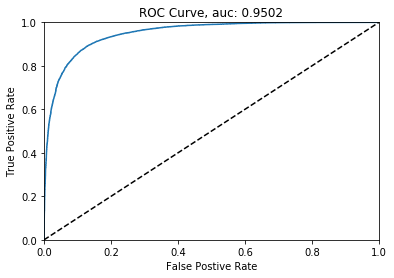

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,
                        lr.predict_proba(X_test_tfidf)[:, [1]])
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, auc: %.4f" % auc);

In [37]:
%%time
from sklearn import naive_bayes, ensemble
bayes = naive_bayes.MultinomialNB(alpha=1)
bayes.fit(X_train_tfidf, y_train)
print("accuracy: ", bayes.score(X_test_tfidf, y_test))

accuracy:  0.86184
CPU times: user 287 ms, sys: 64.6 ms, total: 352 ms
Wall time: 330 ms


In [38]:
%%time
est = tree.DecisionTreeClassifier()
est.fit(X_train_tfidf, y_train)
print("accuracy: ", est.score(X_test_tfidf, y_test))

accuracy:  0.70116
CPU times: user 4min 22s, sys: 1.9 s, total: 4min 24s
Wall time: 4min 29s


In [39]:
columns = [None] * len(tfidf.vocabulary_)
for term in tfidf.vocabulary_:
    columns[tfidf.vocabulary_[term]] = term
result = pd.DataFrame({"feature": columns
                    , "importance": est.feature_importances_})
result = result.sort_values("importance", ascending = False)
result = result[result.importance > 0.0]
print("Top 50 terms: ", list(result.feature[:50]))

Top 50 terms:  ['bad', 'worst', 'wast', 'great', 'bore', 'terribl', 'love', 'noth', 'stupid', 'excel', 'poor', 'best', 'perfect', 'wors', 'disappoint', 'beauti', 'poorli', 'thi', 'good', 'well', 'veri', 'enjoy', 'even', 'fail', 'whi', 'act', 'dull', 'tri', 'pointless', 'ridicul', 'unfortun', 'look', 'scene', 'also', 'one', 'plot', 'mess', 'minut', 'see', 'movi', 'stori', 'still', 'time', 'save', 'anyth', 'better', 'thi movi', 'life', 'money', 'one best']


# Important terms for a document 

In [30]:
vocab_by_term = tfidf.vocabulary_
vocab_by_idx = dict({(vocab_by_term[term], term) 
                                 for term in vocab_by_term})

In [31]:
str(vocab_by_term)[:100]

"{'bromwel': 184129, 'high': 643874, 'cartoon': 212410, 'comedi': 269644, 'ran': 1097062, 'time': 139"

In [32]:
str(vocab_by_idx)[:100]

"{1384916: 'thing earli', 57395: 'america honor', 606047: 'grip audienc', 843249: 'mankind repres', 3"

In [33]:
idx = 5
print("Content:\n", X_train[idx])
row = X_train_tfidf[idx]
terms = [(vocab_by_idx[row.indices[i]], row.data[i])
             for i, term in enumerate(row.indices)]
pd.Series(dict(terms)).sort_values(ascending = False)

Content:
 this isn t the comedic robin williams nor is it the quirky insane robin williams of recent thriller fame this is a hybrid of the classic drama without over dramatization mixed with robin s new love of the thriller but this isn t a thriller per se this is more a mystery suspense vehicle through which williams attempts to locate a sick boy and his keeper also starring sandra oh and rory culkin this suspense drama plays pretty much like a news report until william s character gets close to achieving his goal i must say that i was highly entertained though this movie fails to teach guide inspect or amuse it felt more like i was watching a guy williams as he was actually performing the actions from a third person perspective in other words it felt real and i was able to subscribe to the premise of the story all in all it s worth a watch though it s definitely not friday saturday night fare it rates a 7 7 10 from the fiend 


william         0.2183
robin           0.1719
robin william   0.1319
thriller        0.1272
real abl        0.1003
                 ...  
stori           0.0206
charact         0.0202
get             0.0194
thi movi        0.0194
movi            0.0138
Length: 169, dtype: float64

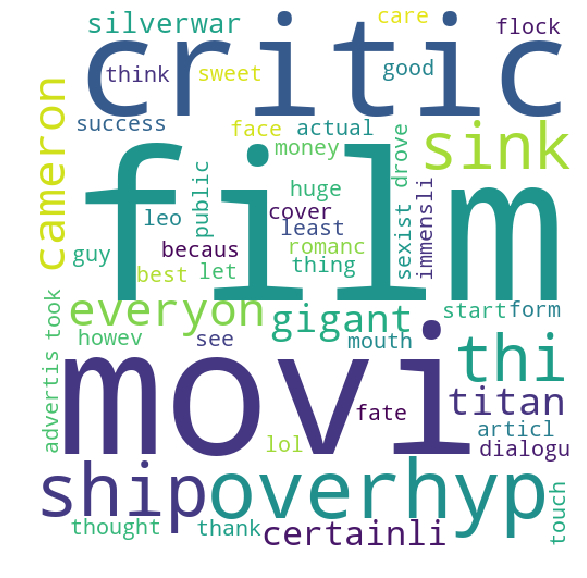

In [34]:
idx = 50
row = X_train_tfidf[idx]
terms = [(vocab_by_idx[row.indices[i]], row.data[i]) 
                 for i, term in enumerate(row.indices)]
top_terms= list(pd.Series(dict(terms))\
                .sort_values(ascending = False)[:50].index)
wc = WordCloud(background_color="white", 
    width=500, height=500, max_words=50).generate("+".join(top_terms))
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off");

# Build Pipeline for classificaiton Model

In [42]:
%%time
tfidf =feature_extraction.text.TfidfVectorizer(
              tokenizer=my_tokenizer
            , stop_words = stopwords
            , ngram_range=(1, 2)
        )

pipe = pipeline.Pipeline([
    ("tfidf", tfidf),
    ("est", linear_model.LogisticRegression(C = 1.0, random_state = 1
                            , n_jobs = 8, solver="saga"))
])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...   penalty='l2', random_state=1, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [43]:
import pickle

In [44]:
with open("/tmp/model.pkl", "wb") as f:
    pickle.dump(pipe, f)

In [47]:
!ls -lh /tmp/model.pkl

-rw-r--r--  1 abulbasar  wheel   123M Sep 28 00:19 /tmp/model.pkl


In [48]:
with open("/tmp/model.pkl", "rb") as f:
    model = pickle.load(f)

In [52]:
model.predict_proba(np.array(["""
when we started watching this series on 
cable i had no idea how addictive it would be 
even when you hate a character you hold back because 
they are so beautifully developed you can almost
understand why they react to frustration fear greed 
or temptation the way they do it s almost as if the
viewer is experiencing one of christopher s learning 
curves i can t understand why adriana would put up with 
christopher s abuse of her verbally physically and 
emotionally but i just have to read the newspaper to 
see how many women can and do tolerate such behavior 
carmella has a dream house endless supply of expensive 
things but i m sure she would give it up for a loving 
and faithful husband or maybe not that s why i watch 
it doesn t matter how many times you watch an episode
you can find something you missed the first five times 
we even watch episodes out of sequence watch season 1 
on late night with commercials but all the language a e 
with language censored reruns on the movie network whenever 
they re on we re there we ve been totally spoiled now i also 
love the malaprop s an albacore around my neck is my favorite of
johnny boy when these jewels have entered our family vocabulary 
it is a sign that i should get a life i will when the series
ends and i have collected all the dvd s and put the collection 
in my will"""]))

array([[0.2331, 0.7669]])

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

class TextPreprocessor(TransformerMixin):
    def __init__(self, kvpairs):
        self.kpairs = kvpairs
        
    def transform(self, X, *_):  
        # Remove html tags
        text = BeautifulSoup(text.lower(), "html5lib").text 

        # Replace the occurrences of multiple consecutive whilespaces 
        # with a single space (" ")
        text = re.sub(r"[\W]+", " ", text)
        return text
    
    def fit(self, *_):
        return self